# Práctica guiada

## Predicción de enfermedad cardíaca con Random Forest

<img src="img/heart-health-tips-animation-thumbnail.gif" alt="hearth">


El hospital de León quiere **predecir riesgo de enfermedad cardíaca** a partir de datos clínicos básicos de pacientes.


El objetivo **no es solo entrenar un modelo**, sino **decidir qué modelo es más adecuado**, cómo configurarlo y **explicar por qué**.

Trabajarás con:

* `heart.csv` → dataset completo
* `heart_disease_4features.csv` → versión reducida y más interpretable

El cuaderno base utiliza **Random Forest**, búsqueda de hiperparámetros y visualización de árboles .

---

## Resultados de aprendizaje trabajados

* **RA2.c** Define el modelo a implementar
* **RA2.d** Implementa la aplicación
* **RA2.e** Evalúa resultados

---

## Entrega

Un **notebook Jupyter** en formato PDF con:

* Código funcional
* Respuestas razonadas en Markdown
* Gráficas y métricas
* Conclusiones claras

---

## ¿Qué es Random Forest?

**Random Forest** es un algoritmo de **aprendizaje automático supervisado** que se utiliza tanto para **clasificación** como para **regresión**.

La idea principal es sencilla:

> En lugar de tomar una decisión con un solo árbol de decisión, Random Forest entrena **muchos árboles distintos** y combina sus resultados para obtener una predicción más fiable.

---

## ¿Cómo funciona?

1. Se crean **muchos subconjuntos distintos** del conjunto de entrenamiento (muestreo con reemplazo).
2. Con cada subconjunto se entrena **un árbol de decisión diferente**.
3. En cada árbol, las divisiones se hacen usando **solo una parte aleatoria de las variables**.
4. Para clasificar un nuevo dato:

   * Cada árbol da su predicción.
   * El modelo final decide por **votación mayoritaria**.

Este proceso reduce los errores debidos a:

* árboles demasiado complejos
* datos ruidosos
* sobreajuste al conjunto de entrenamiento

<img src="img/random-forest.png" alt="random forest">

---

## ¿Por qué no usar un solo árbol de decisión?

Un árbol de decisión:

* es fácil de entender
* pero **muy sensible a los datos**
* puede memorizar el entrenamiento (overfitting)

Random Forest soluciona esto porque:

* combina muchos árboles simples
* promedia sus decisiones
* generaliza mejor a datos nuevos

---

## Ventajas de Random Forest

* Funciona bien con **datos tabulares**
* No necesita normalización de variables
* Captura relaciones **no lineales**
* Es robusto frente al ruido
* Permite estimar la **importancia de las variables**

Por eso es muy utilizado en:

* medicina
* banca
* detección de fraude
* problemas reales con datos estructurados

---

## Inconvenientes

* Es menos interpretable que un solo árbol
* Consume más tiempo y recursos
* No es ideal cuando se necesita un modelo muy simple o explicable al 100%

Más información

[Machine Learning Google](https://developers.google.com/machine-learning/decision-forests?hl=es-419)

[Videotutorial: Random Forests con Python](https://www.youtube.com/watch?v=VfMPslt2wgA)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score
)

## Parte 1 – Exploración y comprensión del dataset (obligatoria)

### 1.1 Carga de datos

Carga ambos datasets y responde:

In [2]:
df = pd.read_csv("data/heart.csv")
df_4features = pd.read_csv("data/heart_disease_4features.csv")

print(df.head())
print(df_4features.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
   Unnamed: 0  age  sex  trestbps  chol  target
0           0   52    1       125   212       0
1           1   53    1       140   203       0
2           2   70    1       145   174       0
3           3   61    1       148   203       0
4           4   62    0       138   294       0


<div style="background-color:green;color:white">

<br>

**Cuestiones (responde en Markdown):**

* ¿Cuántas variables tiene cada dataset?

***heart.csv (df)*** tiene 14 variables y ***heart_disease_4features.csv (df_4features)*** tiene 5 variables.

* ¿Cuál crees que será más fácil de explicar a un médico?

El dataset más simple, con menos variables.

* ¿Qué se pierde al reducir variables?

Es más facil que el modelo generalice, perdiendo precisión.

<br>

---

### 1.2 Variable objetivo

<div style="background-color:green;color:white">

<br>

* Identifica claramente la variable *objetivo*

target

* Explica qué significa *0* y *1*

1 significa que es  probable que el paciente tenga problemas cardiacos, y 0 que es muy poco probable.


* Comprueba si hay **desbalanceo de clases**

Hay muy poco desbalanceo de clases, practicamente nulo.

 <br>

In [3]:
print(df_4features["target"].value_counts())

target
1    526
0    499
Name: count, dtype: int64


## Parte 2 – Primer modelo Random Forest (baseline)

### 2.1 Separación train/test

Usa `train_test_split` con:

* `test_size=0.2`
* `random_state=42`



In [4]:
X = df_4features.drop("target", axis=1)
y = df_4features["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<div style="background-color:green;color:white">

<br>

Explica **por qué fijar la semilla es importante**.

Permite la reproducibilidad, para que otra persona pueda obtener exactamente los mismos resultados que tu, además de que algunos parametros del Random Forest dependen de decisiones aleatorias internas, por lo que fijar la semilla asegura que las comparaciones entre configurciones sean justas.

<br>

---

### 2.2 Entrenamiento inicial

Entrena un **Random Forest controlado**, es decir, **no utilices el modelo con los valores por defecto**.

Para ello:

* Crea un `RandomForestClassifier` fijando **explícitamente varios hiperparámetros**.
* Debes **limitar la complejidad del modelo** para evitar sobreajuste.
* Asegura que el entrenamiento sea **reproducible**.
* Evita que el modelo tome decisiones basadas en **muy pocos ejemplos**.
* (Opcional) Activa una estimación interna del rendimiento.

El modelo debe entrenarse con los datos de entrenamiento (`X_train`, `y_train`).

📌 **Ayuda**
Consulta la documentación oficial de [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) en *scikit-learn* para identificar qué hiperparámetros permiten:

* controlar la profundidad de los árboles,
* fijar el número de árboles,
* imponer un tamaño mínimo en las hojas,
* y garantizar reproducibilidad.




In [5]:
rf_controlado = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

rf_controlado.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=4,
                       random_state=42)

---
## Parte 3 – Evaluación correcta del modelo

Una vez entrenado el modelo, es necesario **evaluar su rendimiento** para comprobar si es capaz de **generalizar correctamente** a datos que no ha visto durante el entrenamiento.

En esta parte no basta con obtener una predicción: se deben analizar **distintas métricas**, ya que cada una aporta información diferente sobre el comportamiento del modelo.

---

### Qué se va a hacer

Se evaluará el modelo utilizando el conjunto de test y se mostrarán:

* **Accuracy**
* **Matriz de confusión**
* **Informe de clasificación (classification report)**

Estas métricas permiten analizar no solo cuántas predicciones acierta el modelo, sino **qué tipo de errores comete**.

---

### Por qué no es suficiente una sola métrica

En problemas de clasificación, especialmente en contextos reales como la medicina, **no todos los errores tienen el mismo impacto**.
Por ejemplo, clasificar como sano a un paciente enfermo puede ser mucho más grave que el error contrario.

Por ello, es imprescindible analizar varias métricas y no quedarse solo con la accuracy.

---

- Accuracy: Indica el **porcentaje total de predicciones correctas**.


- Matriz de confusión: Muestra el **número de aciertos y errores por clase**, permite ver **qué tipo de errores son más frecuentes**.

- Classification report: Resume varias métricas clave para cada clase:

* **Precision**: de las predicciones positivas, cuántas son correctas.
* **Recall (sensibilidad)**: de los casos reales, cuántos detecta el modelo.
* **F1-score**: equilibrio entre precision y recall.

---




In [6]:
y_pred = rf_controlado.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

matriz_confusion = confusion_matrix(y_test, y_pred)
print(f"Matriz de confusión:\n{matriz_confusion}\n")

report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}\n")

Accuracy: 0.751219512195122

Matriz de confusión:
[[73 29]
 [22 81]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       102
           1       0.74      0.79      0.76       103

    accuracy                           0.75       205
   macro avg       0.75      0.75      0.75       205
weighted avg       0.75      0.75      0.75       205




<div style="background-color:green;color:white">

<br>


- ¿El rendimiento del modelo es adecuado?

El rendimiento es bastante bueno.

- ¿Qué clase se predice mejor y cuál peor?

La clase 0 se predice mejor.

- ¿Qué tipo de error consideras más problemático en este contexto y por qué?

Los falsos negativos son más problemáticos, ya que diagnosticar a una persona que realmente tiene alguna enfermedad como si no la tuviera (falso negativo) es más peligroso que diagnosticar a una persona que no tiene ninguna enfermedad como si la tuviera (falso positivo).

- ¿Es suficiente la accuracy en un problema médico?

No, hay que analizar varias métricas.

- Justifica con un ejemplo concreto.

En este caso, la precisión general del modelo es bastante buena (0.75), pero también hay que comprobar el recall para verificar que no haya demasiados falsos negativos, que pudiesen suponer un problema. En este caso, no hay demasiados falsos negativos, aunque se podría reducir.

<br>

---

## Parte 4 – Optimización con GridSearchCV

En esta parte se va a **optimizar el modelo Random Forest entrenado anteriormente** utilizando **validación cruzada**.

En lugar de fijar los hiperparámetros manualmente, se utilizará `GridSearchCV` para **probar distintas combinaciones** de valores y seleccionar automáticamente la que **mejor rendimiento medio** obtenga en validación cruzada.

Se repetirá la **misma estrategia utilizada en el cuaderno base**:

* Se variará la **profundidad máxima de los árboles**.
* Se limitará el **número mínimo de muestras por hoja** para evitar decisiones basadas en pocos datos.
* Se probarán distintos **números de árboles** en el bosque.
* El rendimiento se evaluará mediante **accuracy** y validación cruzada.

El objetivo **no es solo mejorar la métrica**, sino **comparar el modelo optimizado con el modelo controlado anterior** y reflexionar sobre el coste computacional.

---


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "max_depth": [2, 3, 5, 10, 20],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "n_estimators": [10, 30, 50, 100]
}


rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)


A partir del modelo y del conjunto de hiperparámetros definidos anteriormente, configura un proceso de **búsqueda exhaustiva** de hiperparámetros utilizando `GridSearchCV`.

El proceso debe cumplir las siguientes condiciones:

* Utiliza como **estimador** el modelo `RandomForestClassifier` previamente definido.
* Emplea el conjunto de hiperparámetros almacenado en `param_grid`.
* Aplica **validación cruzada** con un número fijo de particiones.
* Evalúa el rendimiento usando una **métrica de clasificación adecuada**.
* Aprovecha todos los núcleos disponibles del sistema.
* Muestra información detallada del proceso de búsqueda.

Al finalizar:

* Identifica los **mejores hiperparámetros** encontrados.
* Recupera el **mejor modelo** entrenado.
* Evalúa dicho modelo sobre el conjunto de test.

📌 **Ayuda**
Consulta la documentación oficial de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que permiten


* indicar el estimador,
* definir la rejilla de parámetros,
* establecer el número de particiones de la validación cruzada,
* seleccionar la métrica de evaluación,
* activar el uso de múltiples núcleos,
* y mostrar el progreso del entrenamiento.




In [12]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

mejor_random_forest = grid_search.best_estimator_

y_pred_best = mejor_random_forest.predict(X_test)

# Accuracy
print("Accuracy en test:", accuracy_score(y_test, y_pred_best))

# Matriz de confusión
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_best))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=10; total time=   0.2s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=10; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=10; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=10; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=10; total time=   0.2s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=30; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=30; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=30; total time=   0.4s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=30; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=30; total time=   0.2s
[CV] END ...max_depth=2, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=2, min_samples_leaf=5, n

<div style="background-color:green;color:white">

<br>

- ¿Qué combinación obtiene mejor resultado?

max_depth: 20

min_samples_leaf: 5

n_estimators: 50


- ¿Ha mejorado realmente frente al modelo inicial?

Si, el modelo ha mejorado, tanto en precisión como en el recall.

- ¿Cuánto tiempo tarda y por qué?

Tarda aproximadamente 40 segundos. Depende de los núcleos que se utilicen y de la cantidad de pruebas.

<br>

---

## Parte 5 – Interpretabilidad: dentro del bosque 

### 5.1 Visualización de un árbol

En esta parte se va a **analizar el interior del modelo Random Forest** para comprender **cómo toma decisiones**.

Un Random Forest está formado por **muchos árboles de decisión**. El modelo final no se basa en uno solo, sino en la **combinación de todos ellos**.
Sin embargo, para entender el funcionamiento interno del modelo, es útil **visualizar uno de esos árboles individuales**.

El objetivo **no es explicar el modelo completo**, sino:

* observar **qué variables utiliza**,
* entender **qué tipo de reglas aprende**,
* y reflexionar sobre **las limitaciones de la interpretabilidad** en modelos de conjunto.


---

### Pistas para la implementación

* Un `RandomForestClassifier` almacena los árboles entrenados en un **atributo interno**.
* Cada árbol puede visualizarse usando una función específica de `sklearn.tree`.
* Es recomendable:

  * fijar el tamaño de la figura,
  * limitar la profundidad del árbol representado,
  * mostrar los nombres de las variables,
  * y colorear los nodos para facilitar la interpretación.

📌 **Ayuda**
Consulta la documentación de:

* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para localizar dónde se almacenan los árboles entrenados.
* [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) para identificar los parámetros que controlan la visualización, los nombres de las variables y la profundidad máxima.



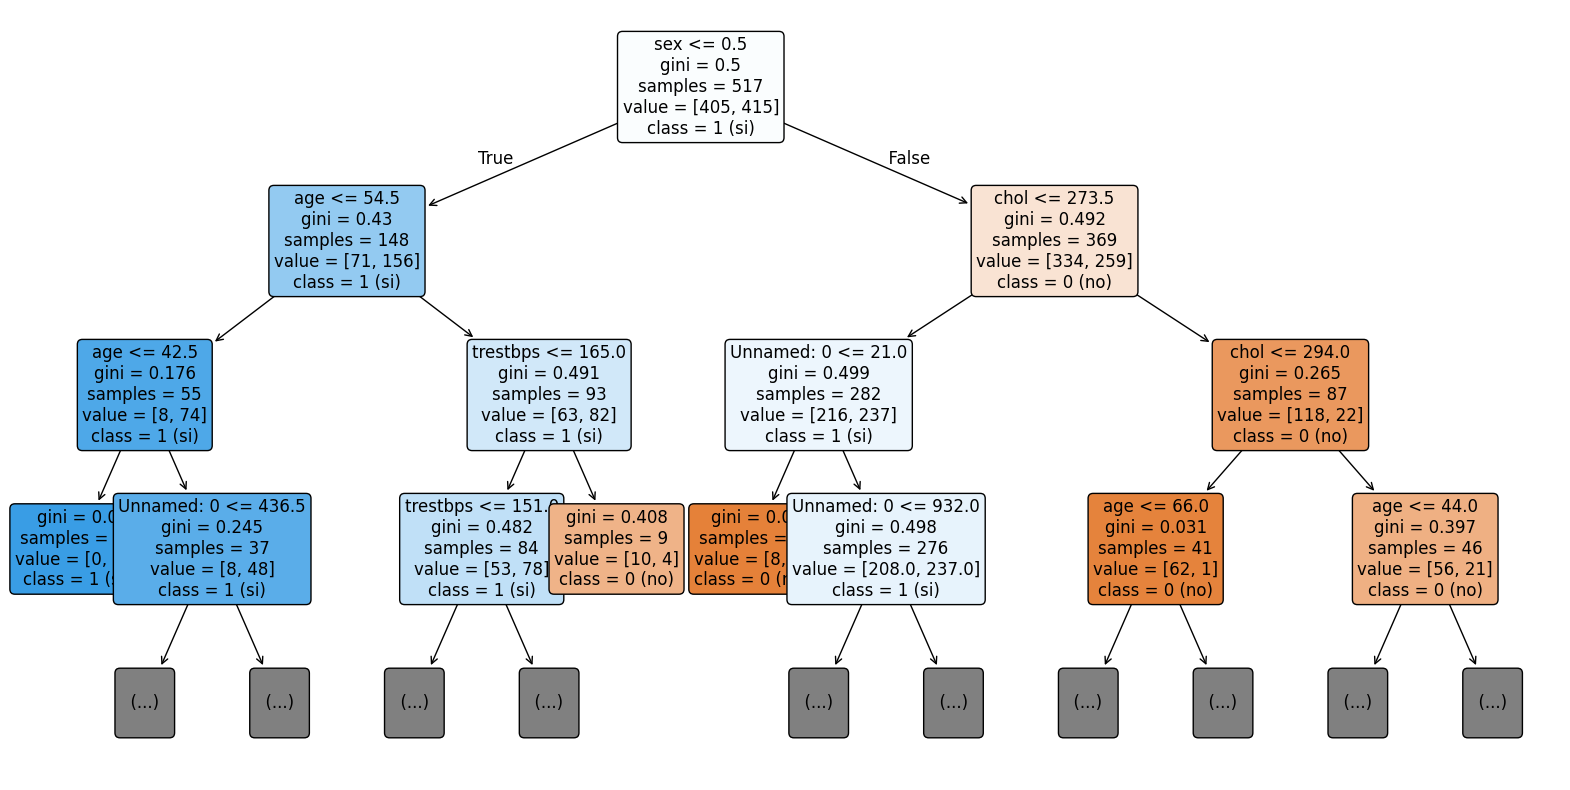

In [15]:
from sklearn.tree import plot_tree

arbol_individual = mejor_random_forest.estimators_[0]

plt.figure(figsize=(20, 10))

plot_tree(
    arbol_individual,
    feature_names=X_train.columns,
    class_names=["0 (no)", "1 (si)"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12
)

plt.show()

<div style="background-color:green;color:white">

<br>

**Explica:**

* Qué variable aparece primero

sex


* Qué significa una condición tipo *chol <= 240*

Si el valor del colesterol es menor igual que 240, va por una rama, sino, ira por la otra.

* Por qué **no debemos mostrar este árbol a un médico como modelo final**

Porque un random forest combina cientos de árboles usando votación o promedio, por lo que visualizar un solo árbol no refleja la decisión final del modelo.


<br>

---

### 5.2 Importancia de variables

En este apartado se va a analizar **qué variables son más importantes para el modelo Random Forest** a la hora de realizar sus predicciones.

Un Random Forest toma decisiones combinando muchos árboles de decisión. En cada árbol, las variables no se usan todas por igual: algunas aparecen con más frecuencia y generan **mejores divisiones** que reducen más la incertidumbre del modelo.
A partir de esta información, el modelo puede estimar la **importancia relativa de cada variable**.

---


#### Pistas para la implementación

* Los modelos `RandomForestClassifier` calculan automáticamente la importancia de las variables tras el entrenamiento.
* Esta información se encuentra en un **atributo del modelo**.
* Para interpretarla correctamente:

  * es conveniente asociar cada valor con el nombre de su variable,
  * y ordenar los resultados para facilitar el análisis.

📌 **Ayuda**
Consulta la documentación de `RandomForestClassifier` para identificar el atributo que almacena la importancia de las variables y su significado.


In [18]:
mejor_random_forest.feature_importances_

importancias = pd.Series(mejor_random_forest.feature_importances_, index=X_train.columns)

importancias = importancias.sort_values(ascending=False)

print("Importancia de variables:")
print(importancias)

Importancia de variables:
chol          0.291814
age           0.282218
trestbps      0.182315
sex           0.124208
Unnamed: 0    0.119445
dtype: float64


<div style="background-color:green;color:white">

<br>

- ¿Coincide con lo que esperarías médicamente?

Si, el colesterol y la edad son factores muy influyentes.

- ¿Qué variable eliminarías si quisieras simplificar aún más?

El sexo del paciente.

<br>

--

## Parte 6 – Comparación crítica de datasets

Entrena **el mismo modelo** con:

* dataset completo
* dataset de 4 variables


---

In [26]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_todas_variables_controlado = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

rf_controlado.fit(X_train, y_train)

y_pred_todas_variables = rf_controlado.predict(X_test)

accuracy_todas_variables = accuracy_score(y_test, y_pred_todas_variables)

matriz_confusion_todas_variables = confusion_matrix(y_test, y_pred_todas_variables)

report_todas_variables = classification_report(y_test, y_pred_todas_variables)

# Accuracy 4 variables
print("Accuracy (4 variables):", accuracy_score(y_test, y_pred_best))
# Matriz de confusión 4 variables
print(f"Matriz de confusión (4 variables):\n{matriz_confusion}\n")
# Reporte de clasificación 4 variables
print(f"Classification Report (4 variables):\n{report}\n")

# Accuracy todas las variables
print(f"Accuracy (Todas las variables): {accuracy_todas_variables}\n")
# Matriz de confusión todas las variables
print(f"Matriz de confusión (Todas las variables):\n{matriz_confusion_todas_variables}\n")
# Reporte de clasificación todas las variables
print(f"Classification Report (Todas las variables):\n{report_todas_variables}\n")

Accuracy (4 variables): 0.8
Matriz de confusión (4 variables):
[[73 29]
 [22 81]]

Classification Report (4 variables):
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       102
           1       0.74      0.79      0.76       103

    accuracy                           0.75       205
   macro avg       0.75      0.75      0.75       205
weighted avg       0.75      0.75      0.75       205


Accuracy (Todas las variables): 0.8634146341463415

Matriz de confusión (Todas las variables):
[[80 22]
 [ 6 97]]

Classification Report (Todas las variables):
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       102
           1       0.82      0.94      0.87       103

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.87      0.86      0.86       205




<div style="background-color:green;color:white">

<br>

Completa una tabla como esta:

| Dataset | Accuracy | Interpretabilidad | Riesgo de overfitting |
| ------- | -------- | ----------------- | --------------------- |
| 4 variables | 0.8 | Sencillo | Alto |
| 14 variables | 0.86 | Complejo | Bajo |

<br>



<div style="background-color:green;color:white">

<br>

¿Qué modelo recomendarías *en un hospital pequeño* y por qué?

El modelo con 4 variables, porque es más sencillo de interpretar y no requiere tantos datos.

<br>

---

## Parte 7 – Reflexión final

Responde brevemente (5–6 líneas cada una):

<div style="background-color:green;color:white">

<br>

1. ¿Por qué Random Forest es una buena elección aquí?

2. ¿Cuándo **no** usarías Random Forest?


3. ¿Qué mejorarías si tuvieras más datos?


<br>
